In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, random_split, ConcatDataset, Subset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
import random
import matplotlib.pyplot as plt

import time
from PIL import Image
from tqdm import tqdm
import os
import cv2
import pandas as pd
import numpy as np
from torchvision.io import read_image

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image_rgb = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 2]

        if self.transform:
            image_rgb = self.transform(image_rgb)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image_rgb, label

In [3]:
# Function to add Gaussian noise
class AddGaussianNoise(torch.nn.Module):
    def __init__(self, mean=0.0, std=0.05, p=0.3):
        super().__init__()
        self.mean = mean
        self.std = std
        self.p = p

    def forward(self, tensor):
        if random.random() < self.p:  # Apply noise with probability p
            noise = torch.randn_like(tensor) * self.std
            tensor = torch.clamp(tensor + noise, 0, 1)  # Keep values in [0,1]
        return tensor

In [4]:
# Custom CLAHE Transform
class ApplyCLAHE:
    def __init__(self, clip_limit=5.0, tile_grid_size=(8,8), p=1.0):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.p = p  # Probability of applying CLAHE

    def __call__(self, img):
        if random.random() < self.p:  # Apply CLAHE with probability p
            img_np = np.array(img)  # Convert PIL to NumPy
            img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_clahe = clahe.apply(img_gray)

            # Convert back to 3-channel grayscale (DenseNet expects 3 channels)
            img_clahe = cv2.merge([img_clahe, img_clahe, img_clahe])
            return Image.fromarray(img_clahe)  # Convert back to PIL
        return img


In [5]:
# define transformations to apply to the images
train_transform  = T.Compose([
    T.Resize((224, 224)),  # Ensure H, W ≥ 224
    ApplyCLAHE(clip_limit=5.0, tile_grid_size=(8,8), p=1.0),  # Apply CLAHE always
    #T.RandomRotation(degrees=15),  # Random rotation within ±15 degrees
    T.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness & contrast
    T.ToTensor(),  # Converts [0,255] uint8 → [0,1] float32
    AddGaussianNoise(std=0.05, p=0.3),  # Apply Gaussian noise with 30% probability
    T.Normalize(mean=[0.2021, 0.2021, 0.2021], std=[0.2519, 0.2519, 0.2519])  # Normalize using calculated mean and std
])

test_transform  = T.Compose([
    T.Resize((224, 224)),  # Ensure H, W ≥ 224
    ApplyCLAHE(clip_limit=5.0, tile_grid_size=(8,8), p=1.0),  # Apply CLAHE always
    T.ToTensor(),  # Converts [0,255] uint8 → [0,1] float32
    T.Normalize(mean=[0.2021, 0.2021, 0.2021], std=[0.2519, 0.2519, 0.2519])  # Normalize using calculated mean and std    
])

In [6]:
# define transformations to apply to the images (for ImageNet weights)
train_transform_IN  = T.Compose([
    T.Resize((224, 224)),  # Ensure H, W ≥ 224
    #ApplyCLAHE(clip_limit=5.0, tile_grid_size=(8,8), p=1.0),  # Apply CLAHE always
    T.ColorJitter(brightness=0.1, contrast=0.1),  # Random brightness & contrast
    T.ToTensor(),  # Converts [0,255] uint8 → [0,1] float32
    AddGaussianNoise(std=0.05, p=0.3),  # Apply Gaussian noise with 30% probability
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform_IN  = T.Compose([
    T.Resize((224, 224)),  # Ensure H, W ≥ 224
    #ApplyCLAHE(clip_limit=5.0, tile_grid_size=(8,8), p=1.0),  # Apply CLAHE always
    T.ToTensor(),  # Converts [0,255] uint8 → [0,1] float32
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize  
])

In [7]:
# cropped and flipped calcification data
calc_train_label_dir = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Calc-Training-png-cropped/labels/calc-train_labels.csv"
calc_test_label_dir = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Calc-Test-png-cropped/labels/calc-test_labels.csv"

calc_train_img_dir = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Calc-Training-png-cropped/images"
calc_test_img_dir = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Calc-Test-png-cropped/images"

# now apply the transformations to the calcification images
calc_training_data = CustomImageDataset(calc_train_label_dir, calc_train_img_dir, train_transform_IN)
calc_test_data = CustomImageDataset(calc_test_label_dir, calc_test_img_dir, test_transform_IN)

# cropped and flipped mass data
mass_train_label_dir = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Mass-Training-png-cropped/labels/mass-train_labels.csv"
mass_test_label_dir = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Mass-Test-png-cropped/labels/mass-test_labels.csv"

mass_train_img_dir = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Mass-Training-png-cropped/images"
mass_test_img_dir = "/kaggle/input/ddsm-cbis-cropped/Data png cropped/Mass-Test-png-cropped/images"

# now apply the transformations to the mass images
mass_training_data = CustomImageDataset(mass_train_label_dir, mass_train_img_dir, train_transform_IN)
mass_test_data = CustomImageDataset(mass_test_label_dir, mass_test_img_dir, test_transform_IN)

In [8]:
# Merge training datasets
combined_train_data = ConcatDataset([calc_training_data, mass_training_data])

# Merge test datasets
combined_test_data = ConcatDataset([calc_test_data, mass_test_data])

# split training data into train and validation (maintaining the labels balanced in both datasets)
from sklearn.model_selection import train_test_split

# Define validation split sizes (80% train, 20% validation)
val_size = 0.2

# Extract labels
labels = []
for dataset in combined_train_data.datasets:  # Access individual datasets
    labels.extend(dataset.img_labels.iloc[:, 2].tolist())  # Extract labels

# Perform stratified split
train_idx, val_idx = train_test_split(
    np.arange(len(combined_train_data)), 
    test_size = val_size, 
    stratify = labels,  # Ensures label distribution is maintained
    random_state = 42
)

# Create subsets
train_dataset = Subset(combined_train_data, train_idx)
val_dataset = Subset(combined_train_data, val_idx)

# shuffle validation and testing datasets once before creating the dataloaders
# Create shuffled indices
val_indices = np.random.permutation(len(val_dataset))
test_indices = np.random.permutation(len(combined_test_data))

# Apply shuffled indices to dataset
shuffled_val_data = Subset(val_dataset, val_indices)
shuffled_test_data = Subset(combined_test_data, test_indices)

# Check dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(shuffled_val_data)}")
print(f"Total testing samples: {len(shuffled_test_data)}")

Training samples: 1953
Validation samples: 489
Total testing samples: 639


In [9]:
# Create DataLoaders
batch_size = 32  # Adjust based on your GPU memory
num_workers = 4

# shuffle = True
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=num_workers)
# shuffle = False, so that the batches don't change every epoch, making it easier to compare results
val_dataloader = DataLoader(shuffled_val_data, batch_size=batch_size, pin_memory=True, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(shuffled_test_data, batch_size=batch_size, pin_memory=True, shuffle=False, num_workers=num_workers)


(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


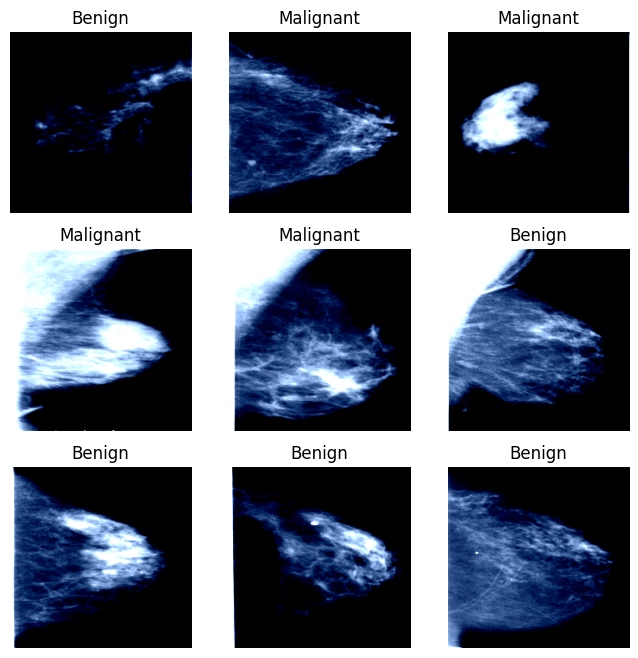

In [11]:
labels_map = {
    0: "Benign",
    1: "Malignant",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(shuffled_test_data), size=(1,)).item()
    img, label = shuffled_test_data[sample_idx]
    #print(img.shape)

    image_np = np.array(img)  # Convert to NumPy array
    print(image_np.shape)

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    #plt.imshow(img.squeeze(), cmap="gray")
    if(torch.is_tensor(img)):
        plt.imshow(img.permute(1, 2, 0))
    else:
        plt.imshow(img)
plt.show()

In [12]:
# training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    running_loss = 0.0  # To accumulate the loss in each batch
    correct_predictions = 0  # To accumulate the number of correct predictions

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Training", leave=True):
    #for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True).view(-1, 1).float()  # Reshape target to match pred (batch_size, 1)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Accumulate loss
        running_loss += loss.item() 

        # Calculate accuracy
        pred_labels = (pred.sigmoid() > 0.5).float()  # Convert logits to binary predictions
        correct_predictions += (pred_labels == y).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        #if batch % 4 == 0:
        #    loss, current = loss.item(), (batch + 1) * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Calculate overall training accuracy
    epoch_accuracy = correct_predictions / size * 100
    
    # You can calculate and store the average loss at the end of each epoch
    epoch_loss = running_loss / len(dataloader)  # Average loss for the epoch
    print(f"Epoch Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")

    return epoch_loss, epoch_accuracy

In [13]:
# validation
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    test_loss, correct = 0, 0
    all_labels = []
    all_preds = []
    all_probs = []  # Stores probability scores for AUC calculation

    with torch.no_grad():
        #for X, y in dataloader:
        for X, y in tqdm(dataloader, desc="Testing", total=num_batches, leave=True):
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True).view(-1, 1).float()  # Reshape target to match pred (batch_size, 1)
            pred = model(X)
            prob = pred.sigmoid()  # Convert logits to probabilities
            pred_labels = (prob > 0.5).float()  # Convert probabilities to binary labels
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred_labels == y).sum().item()
            
            all_labels.extend(y.cpu().numpy())  # Collect true labels
            all_preds.extend(pred_labels.cpu().numpy())  # Collect predicted labels
            all_probs.extend(prob.cpu().numpy())  # Collect predicted probabilities

    # Compute overall statistics
    test_loss /= num_batches
    accuracy = correct / size * 100
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Test Error: \n Accuracy: {accuracy:.1f}%, Avg loss: {test_loss:.6f}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}, AUC: {auc:.3f}\n")

    return test_loss, accuracy, precision, recall, f1, auc

In [14]:
# final testing
def test_final(dataloader, model, num_rows=2):
    print("\nEvaluating on Test Set...")
    num_batches = len(dataloader)
    
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []
    
    sample_images = []
    sample_labels = []
    sample_preds = []
    sample_confidences = []

    num_examples = num_rows * 5  # 5 images per row

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing", total=num_batches, leave=True):
            X, y = X.to(device), y.to(device).view(-1, 1).float()
            pred = model(X)
            prob = pred.sigmoid()  # Convert logits to probabilities
            pred_labels = (prob > 0.5).float()  # Convert to binary labels

            correct += (pred_labels == y).sum().item()
            total += y.size(0)

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(pred_labels.cpu().numpy())
            all_probs.extend(prob.cpu().numpy())

            # Store some sample predictions
            if len(sample_images) < num_examples:
                for i in range(min(num_examples - len(sample_images), X.shape[0])): 
                    sample_images.append(X[i].cpu()) 
                    sample_labels.append(int(y[i].cpu().item()))
                    sample_preds.append(int(pred_labels[i].cpu().item()))

                    # Compute adjusted confidence score
                    prob_value = prob[i].cpu().item()
                    if pred_labels[i] == 1:
                        confidence = (prob_value - 0.5) * 200
                    else:
                        confidence = (0.5 - prob_value) * 200

                    sample_confidences.append(confidence)

    # Compute final metrics
    accuracy = correct / total * 100
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}, AUC: {auc:.3f}")

    # Plot sample predictions in multiple rows
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    fig.suptitle("Sample Predictions", fontsize=16)

    for i in range(num_examples):
        row = i // 5  # Row index
        col = i % 5   # Column index
        
        img = sample_images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy image
        true_label = "Malignant" if sample_labels[i] == 1 else "Benign"
        pred_label = "Malignant" if sample_preds[i] == 1 else "Benign"
        confidence = sample_confidences[i]  # Adjusted confidence score

        axes[row, col].imshow(img, cmap="gray")
        axes[row, col].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%")
        axes[row, col].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

    return accuracy, precision, recall, f1, auc


In [15]:
import torch.nn.functional as F
import numpy as np
from matplotlib import colormaps
from torchvision.transforms.functional import to_pil_image
import PIL
from PIL import Image

# Define global variables for Grad-CAM
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output  # Store gradients from backpropagation

def forward_hook(module, args, output):
    global activations
    activations = output  # Store feature maps from forward pass

def generate_gradcam(model, image):
    """
    Generates Grad-CAM heatmap for a given image.
    """
    global gradients, activations
    
    model.zero_grad()  # Clear previous gradients
    output = model(image)
    prob = output.sigmoid()
    pred_label = (prob > 0.5).float()
    
    # Backward pass to get gradients
    output.backward(torch.ones_like(output))  
    
    # Pool gradients across the channels
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

    # Weight the channels by corresponding gradients
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Compute heatmap
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = F.relu(heatmap)  # Apply ReLU
    heatmap /= torch.max(heatmap)  # Normalize

    # Remove hooks
    #forward_handle.remove()
    #backward_handle.remove()
    
    return heatmap.detach().cpu()

def overlay_heatmap(img_tensor, heatmap):
    """
    Overlays the Grad-CAM heatmap on the original image.
    """

    unnorm_img = unnormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    original_img = to_pil_image(unnorm_img.clamp(0, 1), mode='RGB')  # Convert tensor to PIL image

    # Resize the heatmap to match image size
    overlay = to_pil_image(heatmap, mode='F').resize((224, 224), resample=PIL.Image.BICUBIC)

    # Apply colormap
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

    return original_img, overlay  # Return original image and overlay

# Function to unnormalize images
def unnormalize(img_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img_tensor * std + mean  # Reverse normalization


In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.metrics import roc_curve, auc as calc_auc  # rename to avoid conflict with your 'auc' variable
from sklearn.metrics import precision_recall_curve, average_precision_score

def test_final3(dataloader, model, model_code, num_rows=2):
    print("\nEvaluating on Test Set...")
    num_batches = len(dataloader)
    
    model.eval()
    
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []
    
    sample_images = []
    sample_heatmaps = []
    sample_labels = []
    sample_preds = []
    sample_confidences = []

    num_examples = num_rows * 5  # 5 images per row
    
    # Identify the last convolutional layer
    if model_code == "densenet121":
        last_conv_layer = model.features.denseblock4.denselayer16.conv2
    elif model_code == "densenet169":
        last_conv_layer = model.features.denseblock4.denselayer32.conv2
    elif model_code == "mobilenetv3":
        last_conv_layer = model.features[-1][0]
    elif model_code == "efficientnetB0":
        last_conv_layer = model.features[-1][0]
    # Register hooks for Grad-CAM
    backward_hook_handle = last_conv_layer.register_full_backward_hook(backward_hook)
    forward_hook_handle = last_conv_layer.register_forward_hook(forward_hook)
    
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing", total=num_batches, leave=True):
            X, y = X.to(device), y.to(device).view(-1, 1).float()
            pred = model(X)
            prob = pred.sigmoid()  # Convert logits to probabilities
            pred_labels = (prob > 0.5).float()  # Convert to binary labels

            correct += (pred_labels == y).sum().item()
            total += y.size(0)

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(pred_labels.cpu().numpy())
            all_probs.extend(prob.cpu().numpy())

            # Store sample images and Grad-CAM visualizations
            if len(sample_images) < num_examples:
                for i in range(min(num_examples - len(sample_images), X.shape[0])): 
                    img_tensor = X[i].cpu()
                    # Enable gradients only for Grad-CAM
                    with torch.set_grad_enabled(True):
                        heatmap = generate_gradcam(model, X[i].unsqueeze(0))

                    original_img, overlay_img = overlay_heatmap(img_tensor, heatmap)

                    sample_images.append(original_img)
                    sample_heatmaps.append(overlay_img)
                    sample_labels.append(int(y[i].cpu().item()))
                    sample_preds.append(int(pred_labels[i].cpu().item()))

                    # Compute adjusted confidence score
                    prob_value = prob[i].cpu().item()
                    if pred_labels[i] == 1:
                        confidence = (prob_value - 0.5) * 200
                    else:
                        confidence = (0.5 - prob_value) * 200

                    sample_confidences.append(confidence)

    # Compute final metrics
    accuracy = correct / total * 100
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}, AUC: {auc:.3f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = calc_auc(fpr, tpr)

    # Compute Precision-Recall Curve and Average Precision
    precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_probs)
    avg_precision = average_precision_score(all_labels, all_probs)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(True)

    # Precision-Recall Curve
    axes[1].plot(recall_vals, precision_vals, color='green', lw=2, label=f'AP = {avg_precision:.2f}')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend(loc='lower left')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Plot original images and Grad-CAM heatmaps
    fig, axes = plt.subplots(num_rows * 2, 5, figsize=(15, 6 * num_rows))
    fig.suptitle("Sample Predictions with Grad-CAM", fontsize=16)

    for i in range(num_examples):
        row = (i // 5) * 2
        col = i % 5

        # Plot original image
        axes[row, col].imshow(sample_images[i], cmap="gray")
        true_label = "Malignant" if sample_labels[i] == 1 else "Benign"
        pred_label = "Malignant" if sample_preds[i] == 1 else "Benign"
        confidence = sample_confidences[i]

        axes[row, col].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%")
        axes[row, col].axis("off")

        # Plot Grad-CAM heatmap
        axes[row + 1, col].imshow(sample_images[i], cmap="gray")
        axes[row + 1, col].imshow(sample_heatmaps[i], alpha=0.4, interpolation="nearest")
        axes[row + 1, col].set_title("Grad-CAM")
        axes[row + 1, col].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

    return accuracy, precision, recall, f1, auc


In [17]:
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))
print("Current Device:", torch.cuda.current_device())

GPU Available: True
GPU Name: Tesla T4
Current Device: 0


In [18]:
torch.backends.cudnn.benchmark = True  # Optimizes for fixed-size inputs
torch.backends.cudnn.enabled = True    # Ensures CUDA is used efficiently
#torch.set_num_threads(1)  # Prevents PyTorch from using CPU threads

In [19]:
torch.cuda.empty_cache()  # Frees unused memory
torch.cuda.ipc_collect()  # Helps free memory from inter-process communication

In [36]:
# training MobileNetV3 Large
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR  # Import StepLR
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

# Using pretrained MobileNetV3 large
model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# Check the number of input features for the classifier
num_features = model.classifier[0].in_features

# Modify the classifier for binary classification
model.classifier = nn.Sequential(
    nn.Dropout(0.4), #add 40% Dropout
    nn.Linear(num_features, 1)
)

learning_rate = 1e-4
weight_decay = 1e-4
epochs = 10

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Define loss function and optimizer with weight decay
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.7], device=device))  # Correct loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Add L2 regularization

# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce LR by factor of 0.1 every 5 epochs

cuda:0



Epoch 1
-------------------------------


Training: 100%|██████████| 62/62 [03:30<00:00,  3.39s/it]


Epoch Training Loss: 0.9083, Training Accuracy: 50.79%


Testing: 100%|██████████| 16/16 [00:58<00:00,  3.64s/it]

Test Error: 
 Accuracy: 57.1%, Avg loss: 0.874963
Precision: 0.514, Recall: 0.749, F1-score: 0.610, AUC: 0.644

🕒 Epoch 1 took 4.48 minutes
✅ New best model saved with loss: 0.8750, accuracy: 57.06%, AUC: 0.64

Epoch 1 completed, LR: [0.0001]

Epoch 2
-------------------------------



Training: 100%|██████████| 62/62 [03:38<00:00,  3.52s/it]


Epoch Training Loss: 0.8513, Training Accuracy: 53.71%


Testing: 100%|██████████| 16/16 [00:59<00:00,  3.69s/it]

Test Error: 
 Accuracy: 61.1%, Avg loss: 0.875712
Precision: 0.572, Recall: 0.525, F1-score: 0.548, AUC: 0.644

🕒 Epoch 2 took 4.63 minutes
Epoch 2 completed, LR: [0.0001]

Epoch 3
-------------------------------



Training: 100%|██████████| 62/62 [03:40<00:00,  3.55s/it]


Epoch Training Loss: 0.8075, Training Accuracy: 60.57%


Testing: 100%|██████████| 16/16 [00:59<00:00,  3.73s/it]

Test Error: 
 Accuracy: 60.9%, Avg loss: 0.853196
Precision: 0.546, Recall: 0.758, F1-score: 0.635, AUC: 0.660

🕒 Epoch 3 took 4.67 minutes
✅ New best model saved with loss: 0.8532, accuracy: 60.94%, AUC: 0.66

Epoch 3 completed, LR: [1e-05]

Epoch 4
-------------------------------



Training: 100%|██████████| 62/62 [03:40<00:00,  3.56s/it]


Epoch Training Loss: 0.7463, Training Accuracy: 65.59%


Testing: 100%|██████████| 16/16 [01:00<00:00,  3.76s/it]

Test Error: 
 Accuracy: 62.4%, Avg loss: 0.845768
Precision: 0.573, Recall: 0.630, F1-score: 0.600, AUC: 0.677

🕒 Epoch 4 took 4.68 minutes
✅ New best model saved with loss: 0.8458, accuracy: 62.37%, AUC: 0.68

Epoch 4 completed, LR: [1e-05]

Epoch 5
-------------------------------



Training: 100%|██████████| 62/62 [03:40<00:00,  3.55s/it]


Epoch Training Loss: 0.7375, Training Accuracy: 66.87%


Testing: 100%|██████████| 16/16 [01:00<00:00,  3.77s/it]

Test Error: 
 Accuracy: 64.8%, Avg loss: 0.844347
Precision: 0.601, Recall: 0.639, F1-score: 0.619, AUC: 0.694

🕒 Epoch 5 took 4.68 minutes
✅ New best model saved with loss: 0.8443, accuracy: 64.83%, AUC: 0.69

Epoch 5 completed, LR: [1e-05]

Epoch 6
-------------------------------



Training: 100%|██████████| 62/62 [03:40<00:00,  3.55s/it]


Epoch Training Loss: 0.7284, Training Accuracy: 66.87%


Testing: 100%|██████████| 16/16 [00:57<00:00,  3.60s/it]


Test Error: 
 Accuracy: 64.4%, Avg loss: 0.834107
Precision: 0.593, Recall: 0.653, F1-score: 0.622, AUC: 0.702

🕒 Epoch 6 took 4.63 minutes
✅ New best model saved with loss: 0.8341, accuracy: 64.42%, AUC: 0.70

Epoch 6 completed, LR: [1.0000000000000002e-06]

Epoch 7
-------------------------------


Training: 100%|██████████| 62/62 [03:41<00:00,  3.57s/it]


Epoch Training Loss: 0.7179, Training Accuracy: 68.97%


Testing: 100%|██████████| 16/16 [00:59<00:00,  3.73s/it]

Test Error: 
 Accuracy: 62.6%, Avg loss: 0.841176
Precision: 0.567, Recall: 0.699, F1-score: 0.626, AUC: 0.683

🕒 Epoch 7 took 4.69 minutes
Epoch 7 completed, LR: [1.0000000000000002e-06]

Epoch 8
-------------------------------



Training: 100%|██████████| 62/62 [03:40<00:00,  3.56s/it]


Epoch Training Loss: 0.7089, Training Accuracy: 68.25%


Testing: 100%|██████████| 16/16 [00:59<00:00,  3.71s/it]

Test Error: 
 Accuracy: 63.2%, Avg loss: 0.819637
Precision: 0.567, Recall: 0.753, F1-score: 0.647, AUC: 0.700

🕒 Epoch 8 took 4.67 minutes
✅ New best model saved with loss: 0.8196, accuracy: 63.19%, AUC: 0.70

Epoch 8 completed, LR: [1.0000000000000002e-06]

Epoch 9
-------------------------------



Training: 100%|██████████| 62/62 [03:38<00:00,  3.53s/it]


Epoch Training Loss: 0.7191, Training Accuracy: 68.61%


Testing: 100%|██████████| 16/16 [00:59<00:00,  3.74s/it]

Test Error: 
 Accuracy: 61.6%, Avg loss: 0.827851
Precision: 0.551, Recall: 0.763, F1-score: 0.640, AUC: 0.689

🕒 Epoch 9 took 4.64 minutes
Epoch 9 completed, LR: [1.0000000000000002e-07]

Epoch 10
-------------------------------



Training: 100%|██████████| 62/62 [03:41<00:00,  3.58s/it]


Epoch Training Loss: 0.7082, Training Accuracy: 68.36%


Testing: 100%|██████████| 16/16 [00:58<00:00,  3.67s/it]


Test Error: 
 Accuracy: 61.1%, Avg loss: 0.832935
Precision: 0.549, Recall: 0.735, F1-score: 0.629, AUC: 0.694

🕒 Epoch 10 took 4.68 minutes
Epoch 10 completed, LR: [1.0000000000000002e-07]
Training Done!


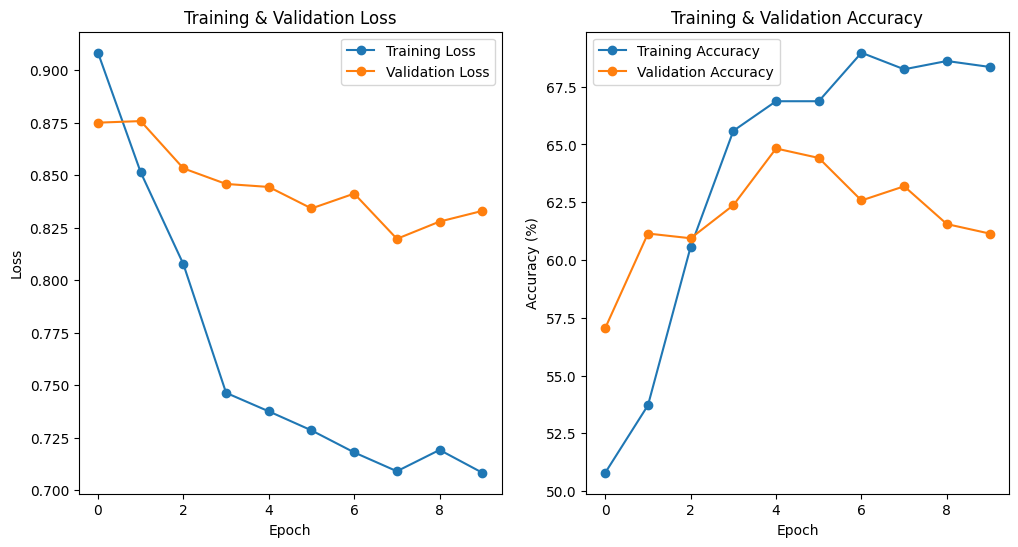

In [37]:
# Initialize tracking lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []
val_aucs = []

# Training loop with validation
patience = 3
patience_counter = 0

# Define path to save the best model
best_model_path = "best_model_run39.pth"

# Initialize variables to track best model
best_val_loss, best_val_auc = float("inf"), 0.0

for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    
    start_time = time.time()
    
    train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc = test(val_dataloader, model, loss_fn)

    end_time = time.time()
    
    epoch_duration = end_time - start_time
    epoch_minutes = epoch_duration / 60
    print(f"🕒 Epoch {t+1} took {epoch_minutes:.2f} minutes")
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_f1s.append(val_f1)
    val_aucs.append(val_auc)

    # Early stopping and best model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)  # Save best model
        print(f"✅ New best model saved with loss: {val_loss:.4f}, accuracy: {val_acc:.2f}%, AUC: {val_auc:.2f}\n")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {t+1}")
        break

    # Step the scheduler at the end of the epoch
    scheduler.step()
    print(f"Epoch {t+1} completed, LR: {scheduler.get_last_lr()}")  # Print updated LR

print("Training Done!")

# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", marker="o")
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


Evaluating on Test Set...


Testing: 100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


Test Accuracy: 58.84%
Precision: 0.494, Recall: 0.602, F1-score: 0.543, AUC: 0.638


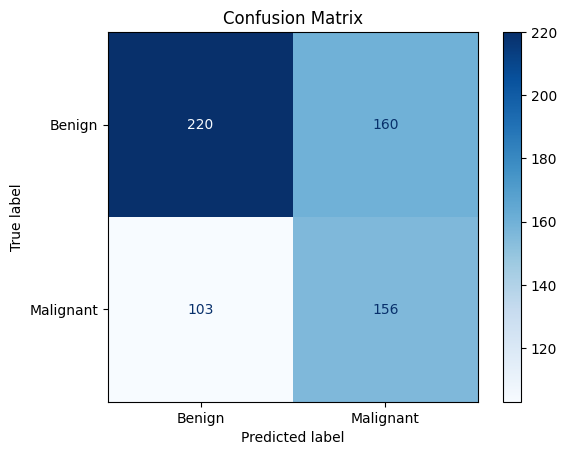

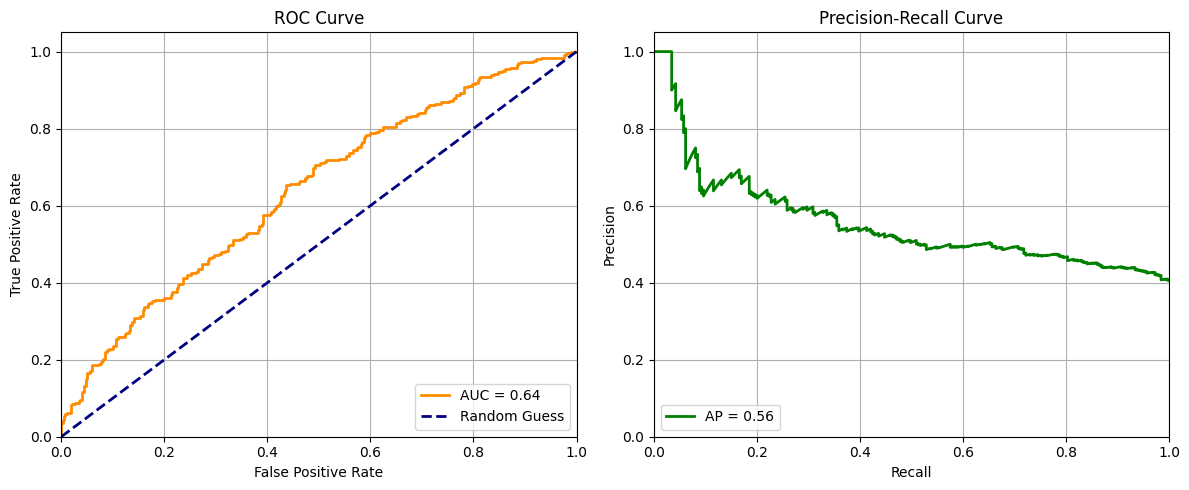

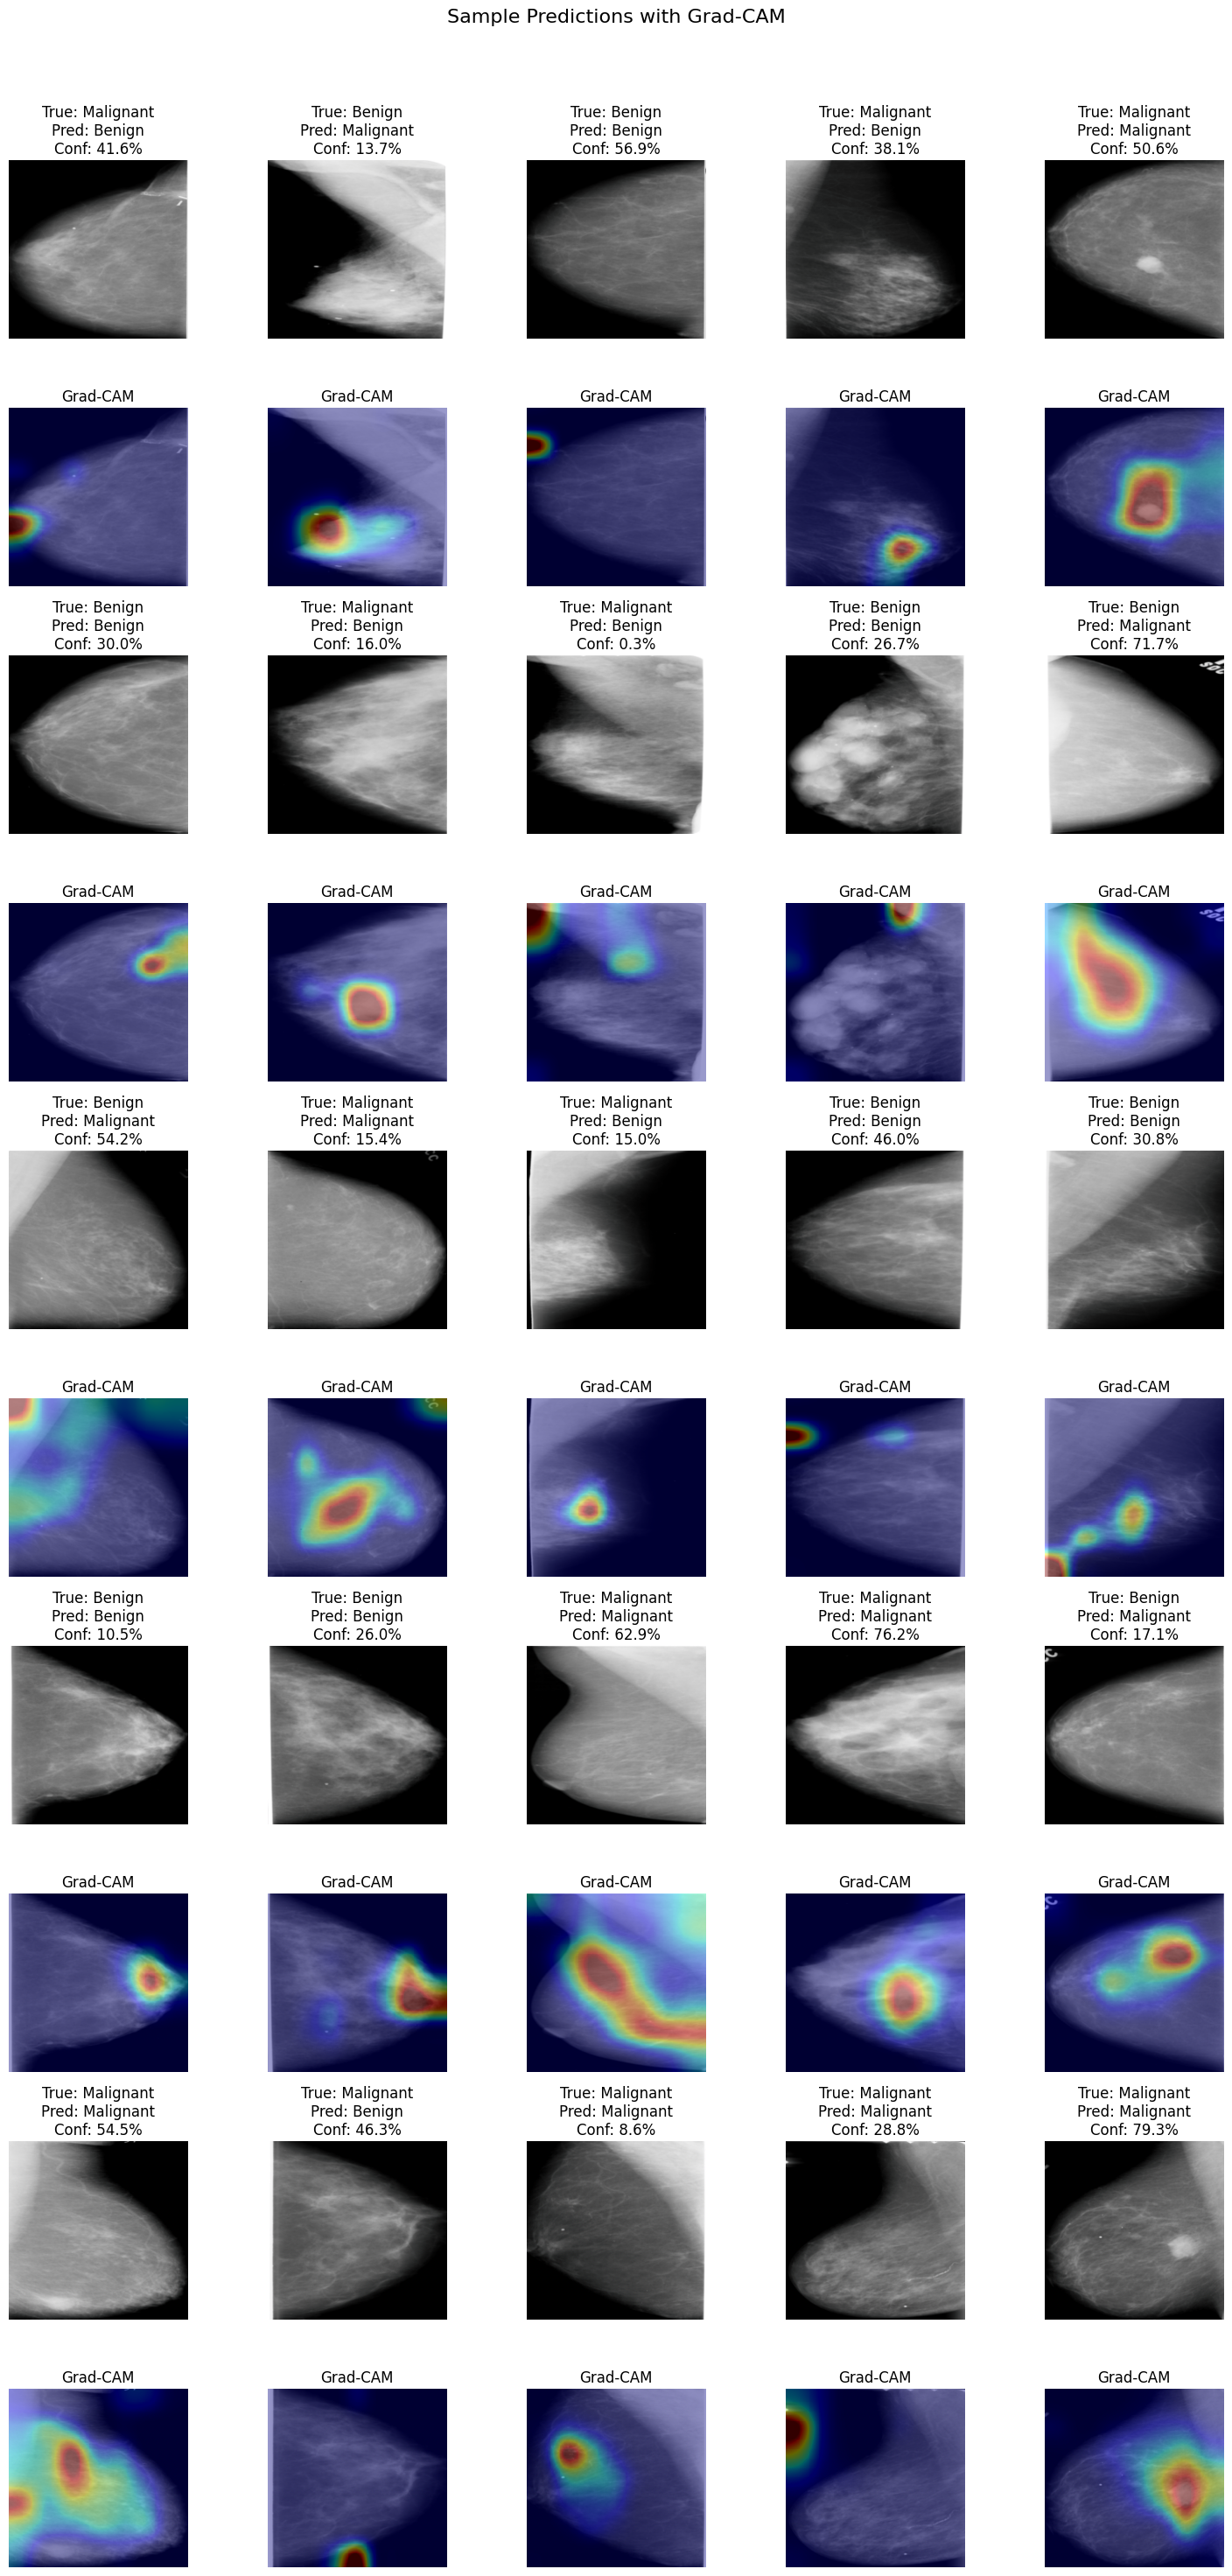

In [39]:
# Load the best model state
best_model_path = "/kaggle/working/best_model_run39.pth"

# Using pretrained MobileNetV3 large
best_model = mobilenet_v3_large(weights=None)

# Check the number of input features for the classifier
num_features = best_model.classifier[0].in_features

# Modify the classifier for binary classification
best_model.classifier = nn.Sequential(
    nn.Dropout(0.4), #add 50% Dropout
    nn.Linear(num_features, 1)
)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)

best_model.load_state_dict(torch.load(best_model_path, weights_only=True))
best_model.eval()  # Set the model to evaluation mode

# Run final test
test_accuracy, test_precision, test_recall, test_f1, test_auc = test_final3(test_dataloader, best_model, model_code="mobilenetv3", num_rows=5)

In [20]:
# training MobileNetV3 Small
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR  # Import StepLR
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# Using pretrained MobileNetV3 small
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

# Check the number of input features for the classifier
num_features = model.classifier[0].in_features

# Modify the classifier for binary classification
model.classifier = nn.Sequential(
    nn.Dropout(0.4), #add 40% Dropout
    nn.Linear(num_features, 1)
)

learning_rate = 1e-4
weight_decay = 1e-4
epochs = 10

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Define loss function and optimizer with weight decay
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.7], device=device))  # Correct loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Add L2 regularization

# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce LR by factor of 0.1 every 5 epochs

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 77.3MB/s]


cuda:0


In [21]:
# Initialize tracking lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []
val_aucs = []

# Training loop with validation
patience = 3
patience_counter = 0

# Define path to save the best model
best_model_path = "best_model_run41.pth"

# Initialize variables to track best model
best_val_loss, best_val_auc = float("inf"), 0.0

for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    
    start_time = time.time()
    
    train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc = test(val_dataloader, model, loss_fn)

    end_time = time.time()
    
    epoch_duration = end_time - start_time
    epoch_minutes = epoch_duration / 60
    print(f"🕒 Epoch {t+1} took {epoch_minutes:.2f} minutes")
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_f1s.append(val_f1)
    val_aucs.append(val_auc)

    # Early stopping and best model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)  # Save best model
        print(f"✅ New best model saved with loss: {val_loss:.4f}, accuracy: {val_acc:.2f}%, AUC: {val_auc:.2f}\n")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {t+1}")
        break

    # Step the scheduler at the end of the epoch
    scheduler.step()
    print(f"Epoch {t+1} completed, LR: {scheduler.get_last_lr()}")  # Print updated LR

print("Training Done!")

# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", marker="o")
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


Epoch 1
-------------------------------


Training: 100%|██████████| 62/62 [03:52<00:00,  3.75s/it]


Epoch Training Loss: 0.9041, Training Accuracy: 47.00%


Testing: 100%|██████████| 16/16 [01:02<00:00,  3.89s/it]


Test Error: 
 Accuracy: 53.4%, Avg loss: 0.903652
Precision: 0.486, Recall: 0.726, F1-score: 0.582, AUC: 0.543

🕒 Epoch 1 took 4.91 minutes
✅ New best model saved with loss: 0.9037, accuracy: 53.37%, AUC: 0.54

Epoch 1 completed, LR: [0.0001]

Epoch 2
-------------------------------


Training: 100%|██████████| 62/62 [03:35<00:00,  3.47s/it]


Epoch Training Loss: 0.8819, Training Accuracy: 50.38%


Testing: 100%|██████████| 16/16 [00:57<00:00,  3.62s/it]

Test Error: 
 Accuracy: 54.4%, Avg loss: 0.897981
Precision: 0.494, Recall: 0.703, F1-score: 0.580, AUC: 0.580

🕒 Epoch 2 took 4.56 minutes
✅ New best model saved with loss: 0.8980, accuracy: 54.40%, AUC: 0.58

Epoch 2 completed, LR: [0.0001]

Epoch 3
-------------------------------



Training: 100%|██████████| 62/62 [03:36<00:00,  3.48s/it]


Epoch Training Loss: 0.8567, Training Accuracy: 54.58%


Testing: 100%|██████████| 16/16 [00:58<00:00,  3.66s/it]

Test Error: 
 Accuracy: 55.8%, Avg loss: 0.880307
Precision: 0.505, Recall: 0.763, F1-score: 0.607, AUC: 0.601

🕒 Epoch 3 took 4.58 minutes
✅ New best model saved with loss: 0.8803, accuracy: 55.83%, AUC: 0.60

Epoch 3 completed, LR: [1e-05]

Epoch 4
-------------------------------



Training: 100%|██████████| 62/62 [03:35<00:00,  3.47s/it]


Epoch Training Loss: 0.8423, Training Accuracy: 56.73%


Testing: 100%|██████████| 16/16 [00:57<00:00,  3.62s/it]

Test Error: 
 Accuracy: 55.2%, Avg loss: 0.884173
Precision: 0.500, Recall: 0.694, F1-score: 0.581, AUC: 0.591

🕒 Epoch 4 took 4.56 minutes
Epoch 4 completed, LR: [1e-05]

Epoch 5
-------------------------------



Training: 100%|██████████| 62/62 [03:33<00:00,  3.45s/it]


Epoch Training Loss: 0.8269, Training Accuracy: 58.68%


Testing: 100%|██████████| 16/16 [00:57<00:00,  3.60s/it]

Test Error: 
 Accuracy: 54.6%, Avg loss: 0.878764
Precision: 0.495, Recall: 0.726, F1-score: 0.589, AUC: 0.599

🕒 Epoch 5 took 4.53 minutes
✅ New best model saved with loss: 0.8788, accuracy: 54.60%, AUC: 0.60

Epoch 5 completed, LR: [1e-05]

Epoch 6
-------------------------------



Training: 100%|██████████| 62/62 [03:40<00:00,  3.55s/it]


Epoch Training Loss: 0.8251, Training Accuracy: 57.60%


Testing: 100%|██████████| 16/16 [00:57<00:00,  3.56s/it]

Test Error: 
 Accuracy: 56.0%, Avg loss: 0.873802
Precision: 0.506, Recall: 0.740, F1-score: 0.601, AUC: 0.617

🕒 Epoch 6 took 4.62 minutes
✅ New best model saved with loss: 0.8738, accuracy: 56.03%, AUC: 0.62

Epoch 6 completed, LR: [1.0000000000000002e-06]

Epoch 7
-------------------------------



Training:  71%|███████   | 44/62 [02:36<01:04,  3.57s/it]


KeyboardInterrupt: 


Evaluating on Test Set...


Testing: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]


Test Accuracy: 60.72%
Precision: 0.522, Recall: 0.367, F1-score: 0.431, AUC: 0.620


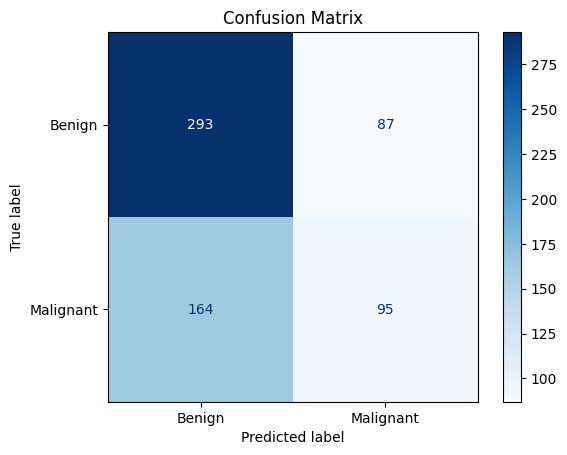

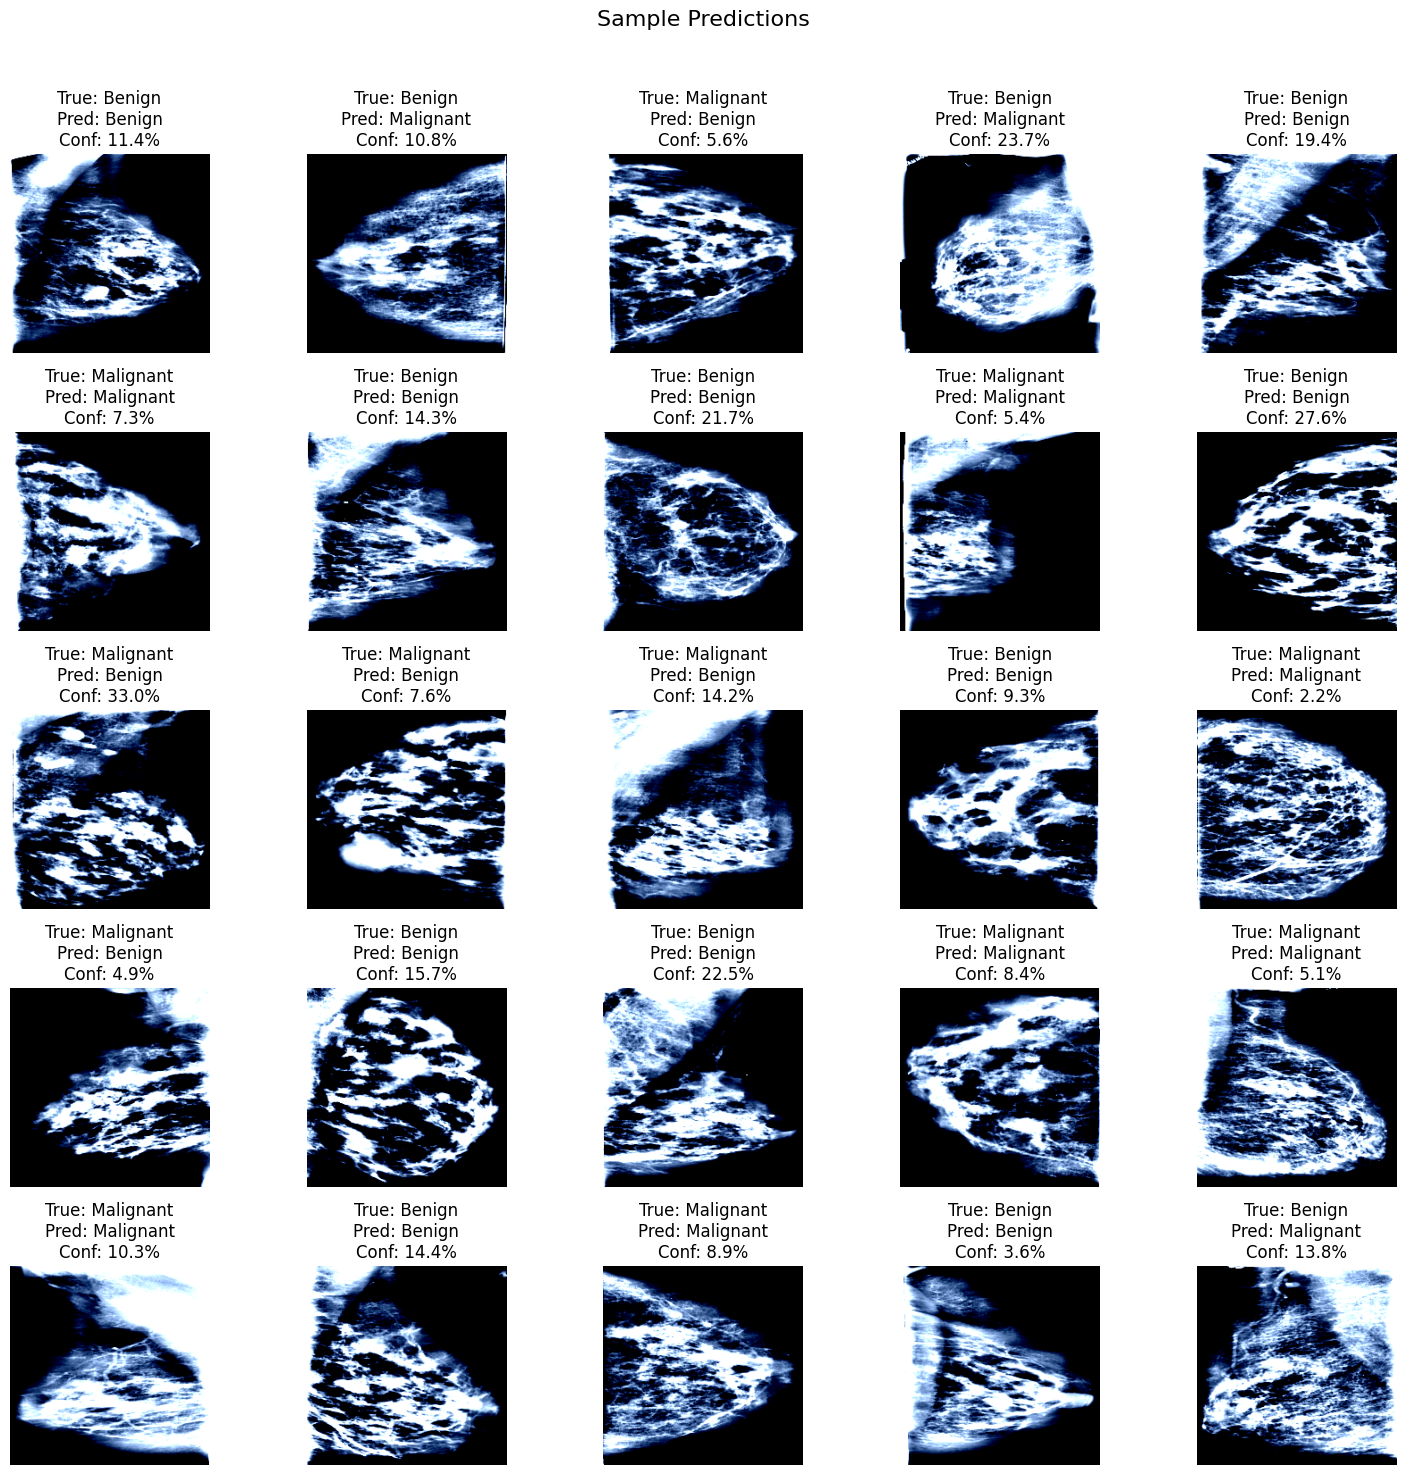

In [46]:
# Load the best model state
best_model_path = "/kaggle/working/best_model_run17.pth"

# Using pretrained MobileNetV3 small
best_model = mobilenet_v3_small(weights=None)

# Check the number of input features for the classifier
num_features = best_model.classifier[0].in_features

# Modify the classifier for binary classification
best_model.classifier = nn.Sequential(
    nn.Dropout(0.4), #add 50% Dropout
    nn.Linear(num_features, 1)
)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)

best_model.load_state_dict(torch.load(best_model_path, weights_only=True))
best_model.eval()  # Set the model to evaluation mode

# Run final test
test_accuracy, test_precision, test_recall, test_f1, test_auc = test_final3(test_dataloader, best_model, model_code="mobilenetv3", num_rows=5)


Evaluating on Test Set...


Testing: 100%|██████████| 10/10 [01:15<00:00,  7.60s/it]


Test Accuracy: 63.07%
Precision: 0.540, Recall: 0.606, F1-score: 0.571, AUC: 0.714


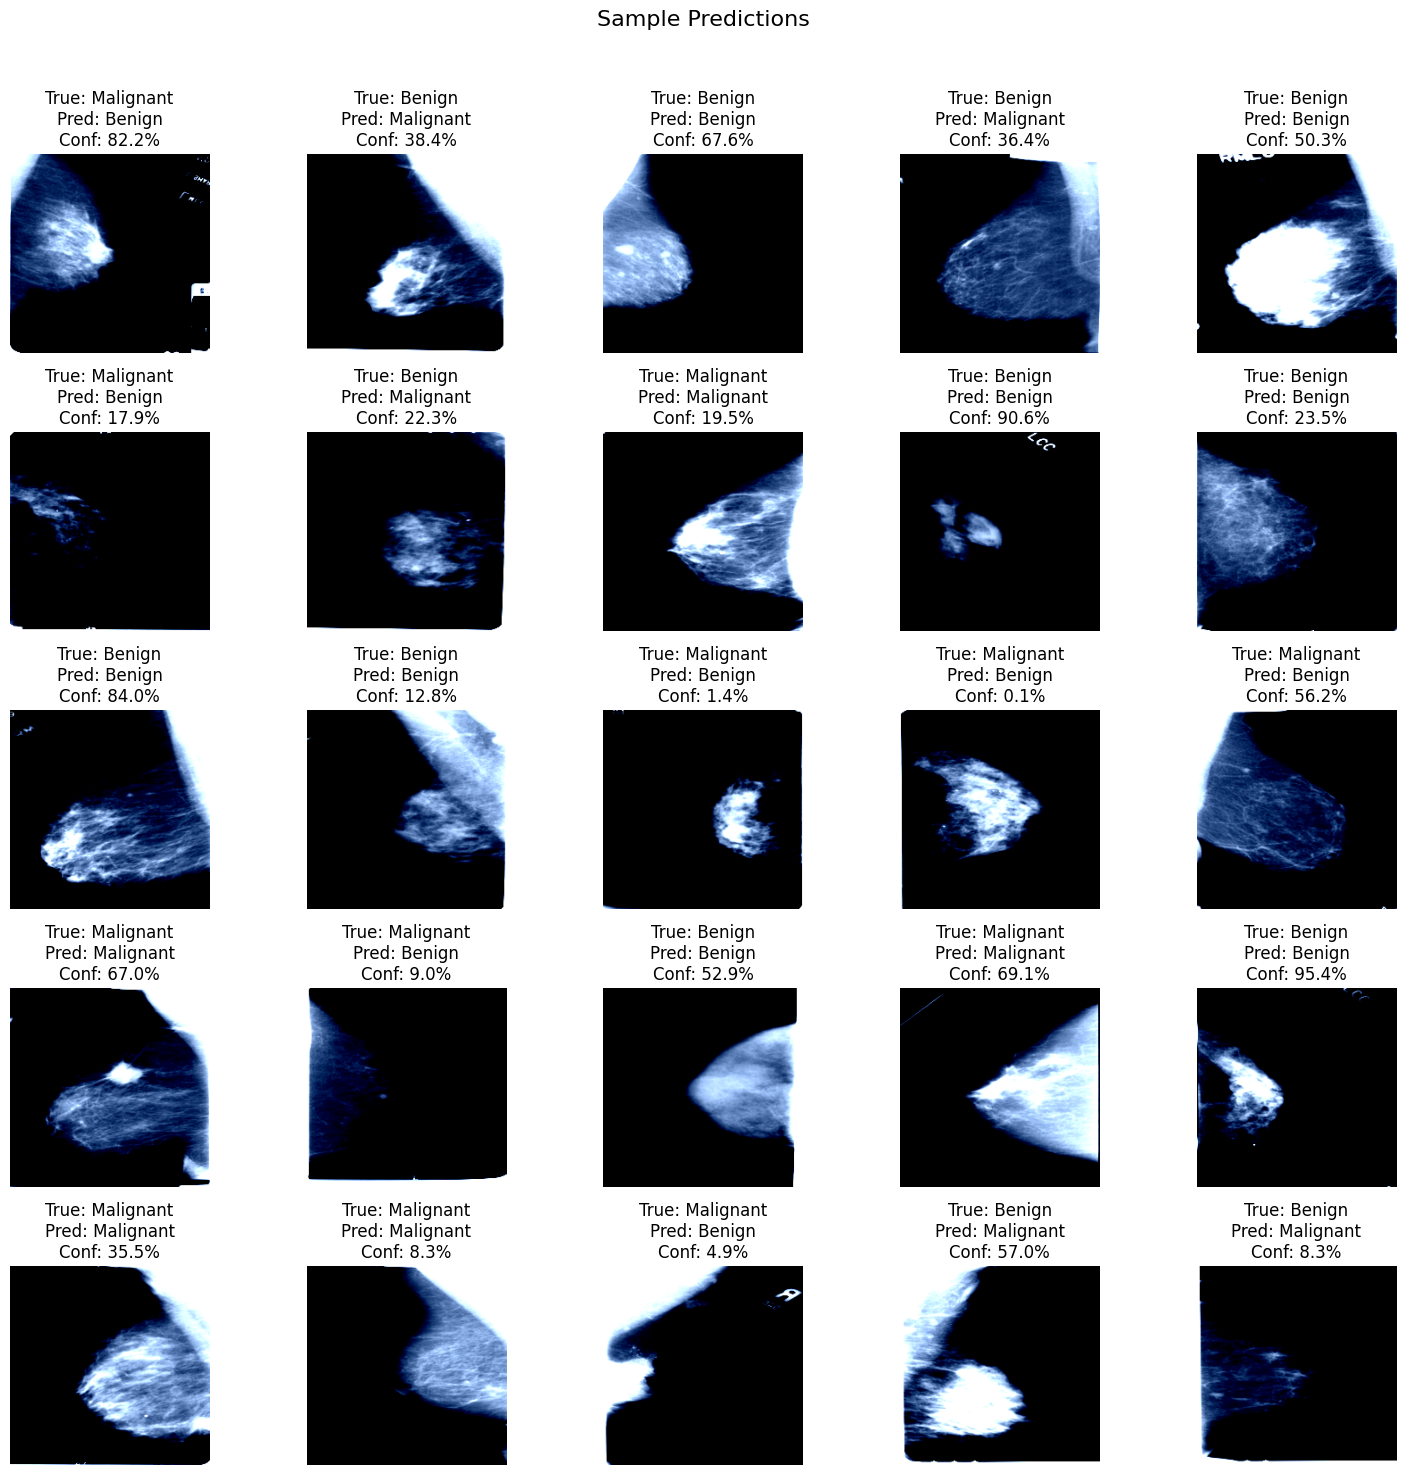

In [35]:
model1.eval()  # Set the model to evaluation mode

# Run final test
test_accuracy, test_precision, test_recall, test_f1, test_auc = test_final(test_dataloader, model1, num_rows=5)